<a href="https://www.kaggle.com/code/sof4raway/iris-classification-using-dnn?scriptVersionId=216100911" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iris/Iris.csv
/kaggle/input/iris/database.sqlite


# Iris Flowers Classification using DNN (Deep Neural Network)
**Data used** : [Iris Dataset (UCIML)](https://www.kaggle.com/datasets/uciml/iris/data)

**Problem** : How we classify Iris flowers from their Sepal and/or Petal Length and Width

**Side Problem** : Which measurements that really differentiate each species

**Author** : Muhammad Farid Rahman | [<img src="https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/brands/linkedin-in.svg" width="10" height="10">](https://www.linkedin.com/in/muhammad-farid-952795217/) | [<img src="https://raw.githubusercontent.com/FortAwesome/Font-Awesome/6.x/svgs/brands/github.svg" width="10" height="10">](https://github.com/SoF4rAway)

### Dataset Loading

Dataset loaded using pandas read_csv() method as the file is a CSV (Comma Separated Values) refer to [Pandas Documentation](https://pandas.pydata.org/docs/reference/frame.html) for detailed usage.

In [2]:
if os.path.isfile(os.path.join('/kaggle/input', 'iris','Iris.csv')):
    df = pd.read_csv(os.path.join('/kaggle/input', 'iris','Iris.csv'),usecols=[col for col in pd.read_csv(os.path.join('/kaggle/input', 'iris','Iris.csv')).columns if col != "Id"])
else:
    print("Not Found")

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

### Notebook Prep
Import all used libraries here, its best practice to import all in one cell for better readability

In [3]:
import os
import sys
import zipfile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import  tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

import keras_tuner as kt
from keras_tuner import HyperModel
from keras_tuner import RandomSearch

# Set the mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Verify the policy setup
print('Compute dtype:', policy.compute_dtype)  # Should output 'float16'
print('Variable dtype:', policy.variable_dtype)  # Should output 'float32'

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

Compute dtype: float16
Variable dtype: float32


### Exploratory Data Analysis
First we conduct a descriptive data analysis so we can get hold on the basics of the dataset, typically we need to know what data types are each column, is there any null value, or is there any non numeric value. 
To do initial data screening we use info(), describe(), and typically head() or tail() method of the Pandas DataFrame object

In [4]:
df.head(5)

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
df.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   SepalLengthCm  150 non-null    float64
 1   SepalWidthCm   150 non-null    float64
 2   PetalLengthCm  150 non-null    float64
 3   PetalWidthCm   150 non-null    float64
 4   Species        150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


From describe and info we can see that there is no null value, however the species column is an object. So we take note from this since Species is our target value

Now lets start on plotting each of the columns inside the dataset to see its distribution

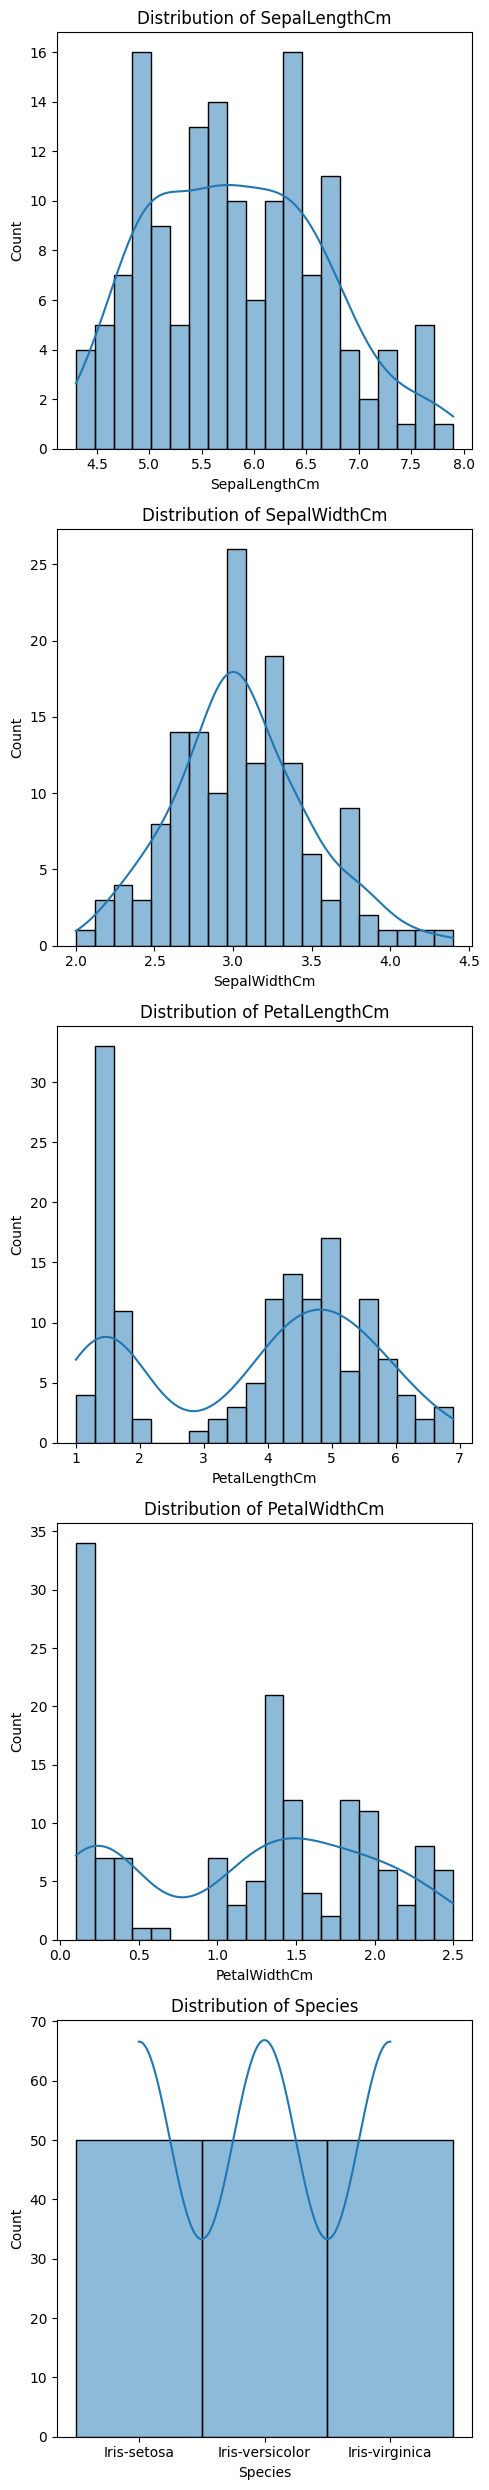

In [7]:
# Number of columns
n_cols = df.columns.shape[0]

# Create subplots
fig, axes = plt.subplots(n_cols, 1, figsize=(5, 5*n_cols))

# Plot each column in a separate subplot
for i in range(n_cols):
    column = df.columns[i]
    sns.histplot(df[column], bins=20, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {column}")

plt.tight_layout()
plt.show()

Of course just seeing the distribution doesnt tell the whole story about the data, we need to dig a bit deeper by doing some multivariate analysis.

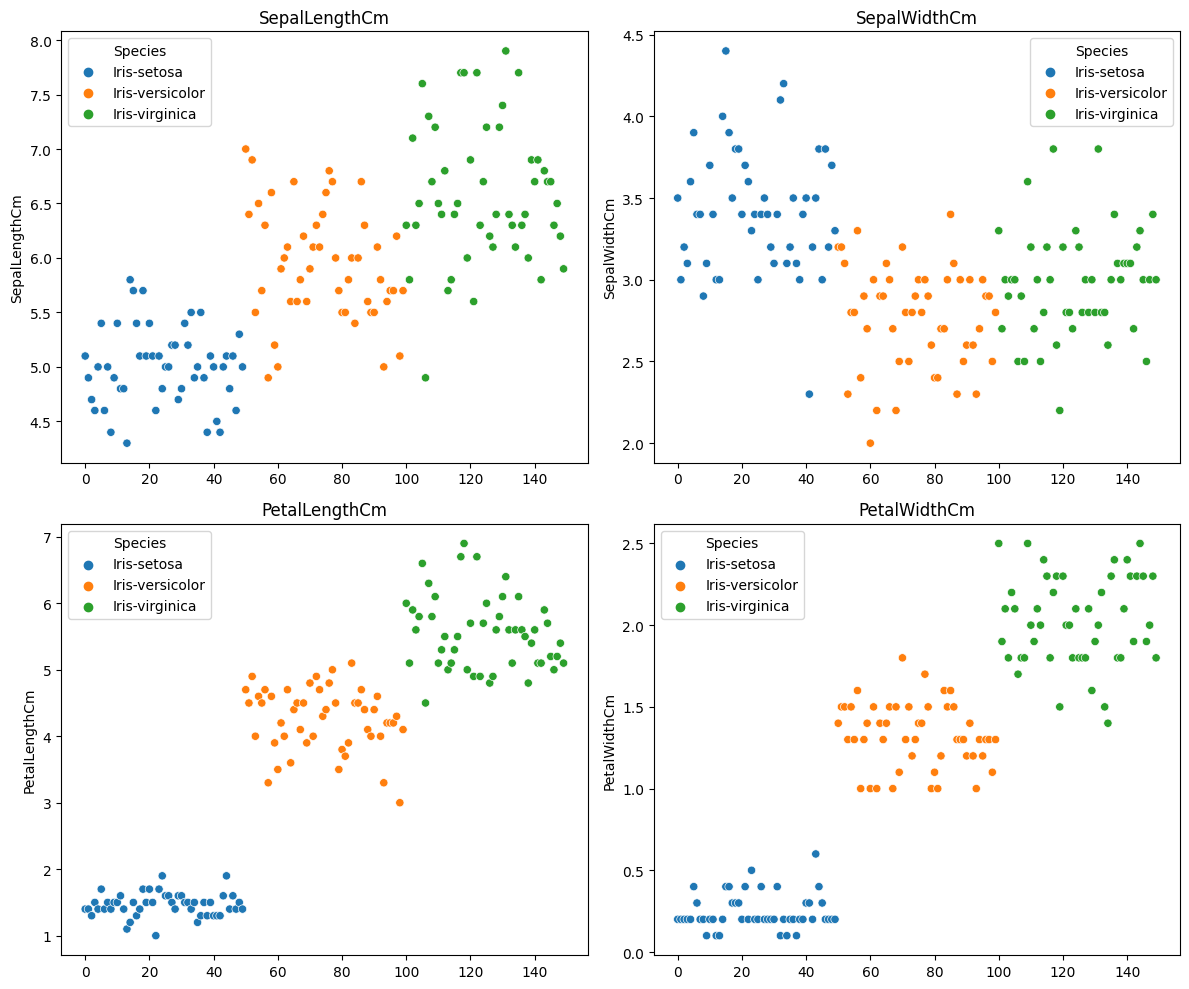

In [8]:
# Number of columns (features) to plot
num_cols = len(df.columns) - 1

# Create a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(df.columns[:-1]):
    sns.scatterplot(ax=axes[i], data=df, x=df.index, y=col, hue="Species")
    axes[i].set_title(col)

# Adjust the layout
plt.tight_layout()
plt.show()

From the scatter plot we can see that in terms of Petal Length and Petal Width each of them is pretty separated with minimal overlaps and also Sepal Length has a bit of overlap but not as much as the Sepal Width. Move on to plotting against each features

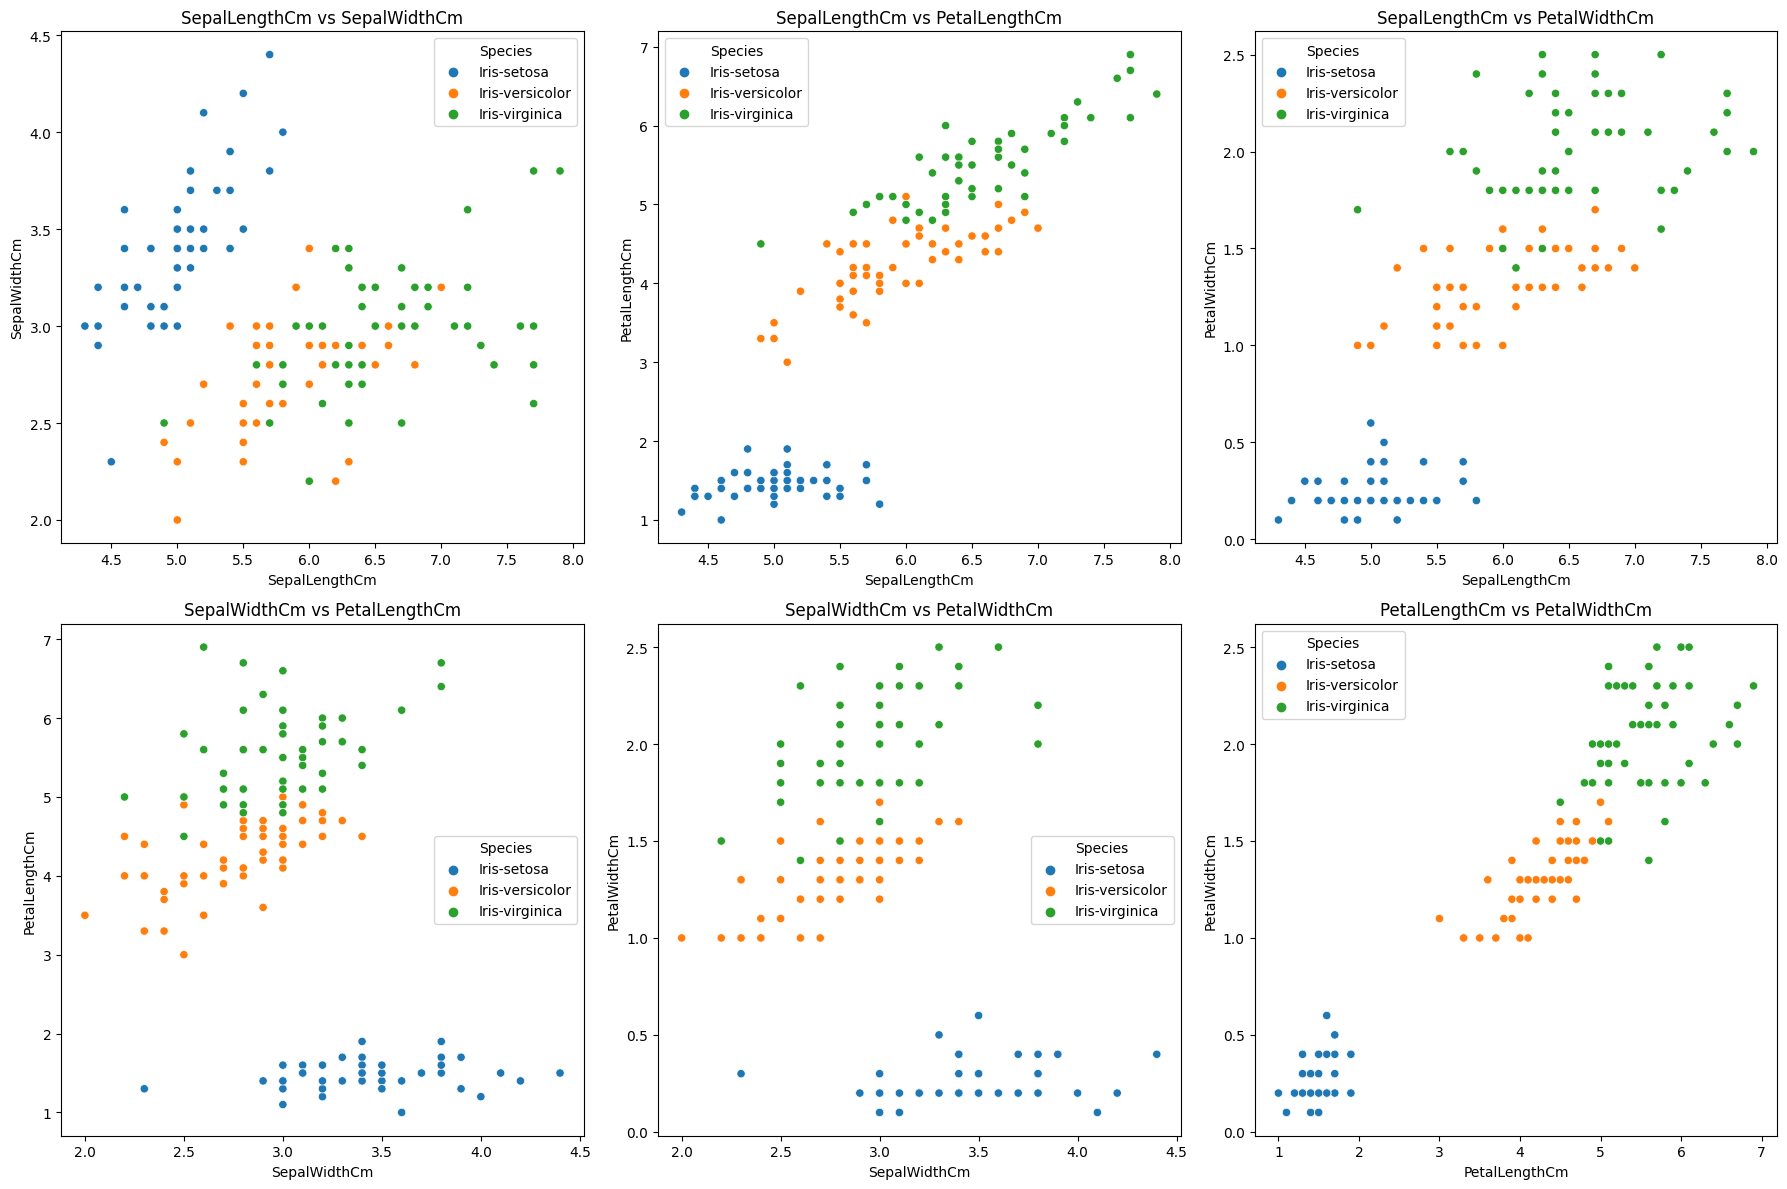

In [9]:
# List of columns to plot
columns = df.columns[:-1]
num_cols = len(columns)

# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot each pair of features without repetition
plot_num = 0
for i in range(num_cols):
    for j in range(i + 1, num_cols):
        sns.scatterplot(ax=axes[plot_num // 3, plot_num % 3], data=df, x=columns[i], y=columns[j], hue="Species")
        axes[plot_num // 3, plot_num % 3].set_title(f'{columns[i]} vs {columns[j]}')
        plot_num += 1

# Adjust the layout
plt.tight_layout()
plt.show()

Well nearly every features if compared against Sepal Width doesnt really create a cluster between each class that is pretty easy to distinguish. Lets see a bit closer from their distribution per each specie

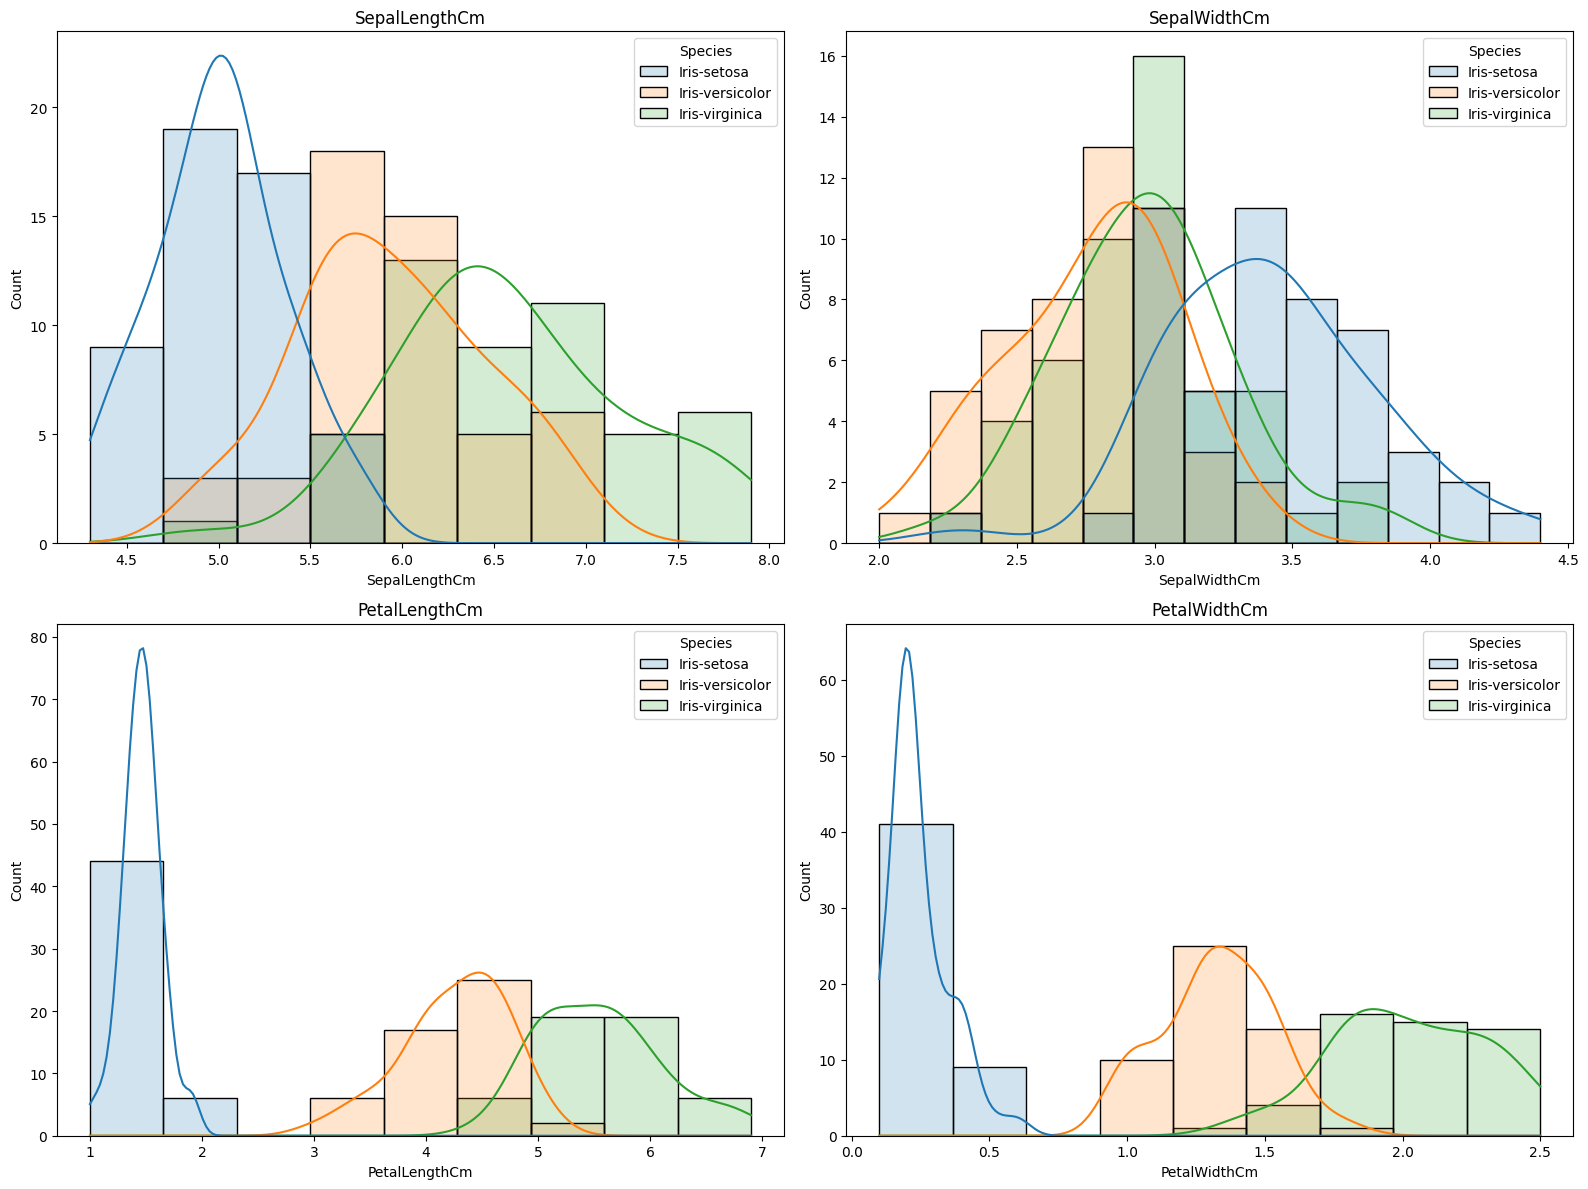

In [10]:
# List of columns to plot
columns = df.columns[:-1]
num_cols = len(columns)

# Create a grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot each feature with histplot, transparency, and KDE in subplots
for i, col in enumerate(columns):
    sns.histplot(ax=axes[i // 2, i % 2], data=df, x=col, hue="Species", kde=True, alpha=0.2)
    axes[i // 2, i % 2].set_title(col)

# Adjust the layout
plt.tight_layout()
plt.show()


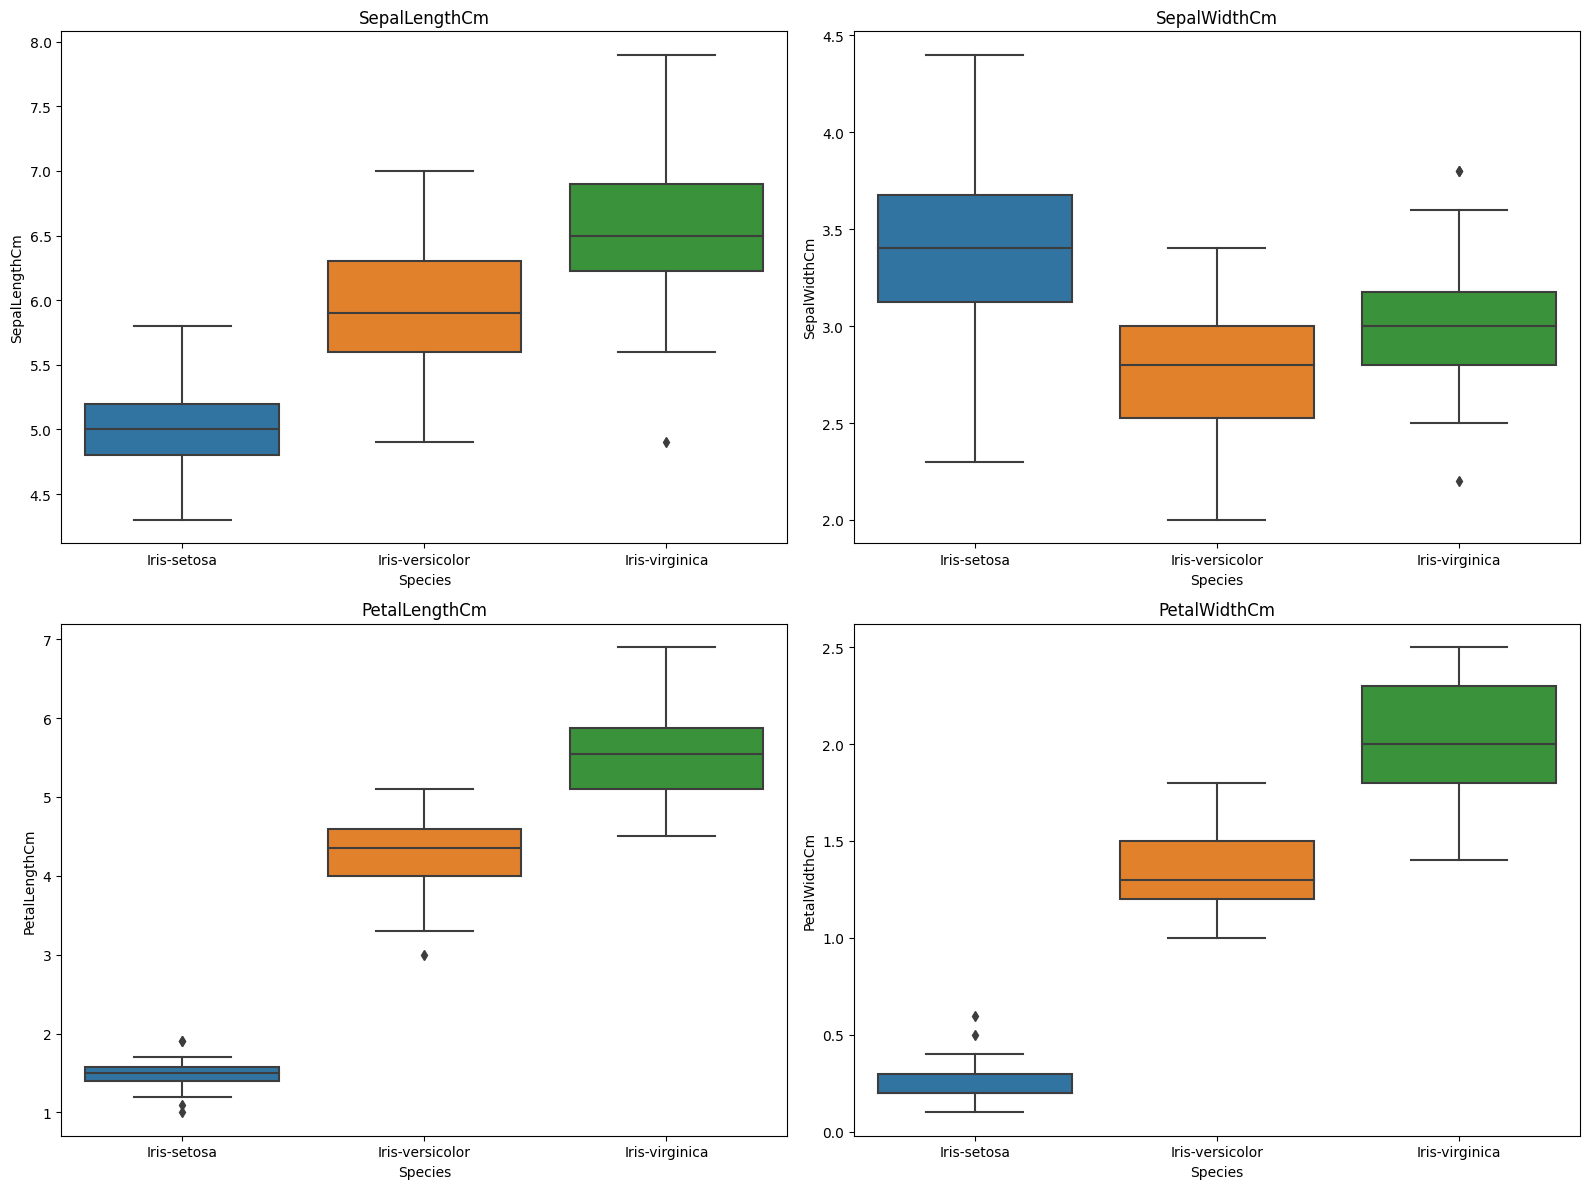

In [11]:
# List of columns to plot
columns = df.columns[:-1]

# Create a grid of box plots
plt.figure(figsize=(16, 12))
for i, col in enumerate(columns):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df, x="Species", y=col)
    plt.title(col)

# Adjust the layout
plt.tight_layout()
plt.show()


 As expected there is many overlap in Sepal Width and Sepal Length feature, however Sepal Length is not as bad as the Sepal Width. From this we'll use only the Sepal Length, Petal Length, and Petal Width as features for our Classification Models. Sepal Length is chosen so we can add a bit more context to our model. But we need to be taking precaution since there is some outliers in the data. But in this case since the data is pretty limited we'll just include those outliers and doesnt even bother to process it

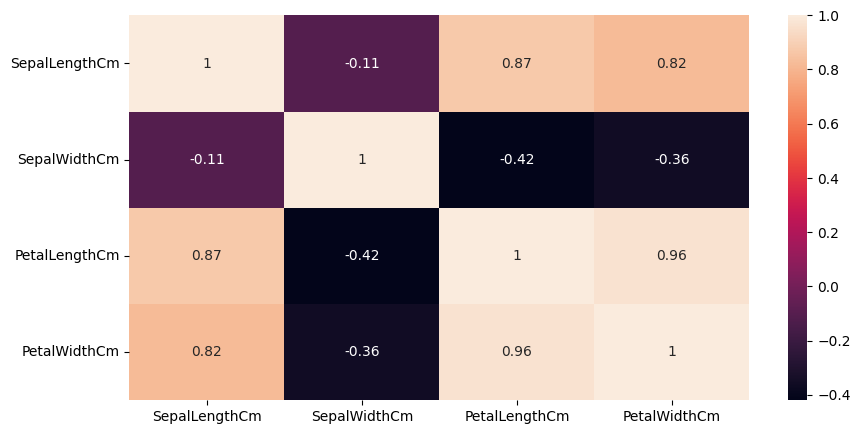

In [12]:
# Compute the correlation matrix, excluding the "Species" column
corr = df.drop(columns="Species").corr()

# Plot the heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(corr, annot=True)
plt.show()


Also looking at the Correlation Matrix, Sepal Length have good correlation with Petal Length and Petal Width.

### Data Prep for Neural Networks

Preparing data for neural networks involves a series of important steps to ensure that the data is in the right format and structure for effective training and evaluation. Let's break down each step:

1. Separating Features and Targets
   * **Features (X)**: These are the input variables that the model will use to make predictions. In this case, the sepal and petal lengths and widths of the Iris flowers.
   * **Targets (y)**: These are the output variables that the model is trying to predict. For the Iris dataset, the target is the species of the Iris flower.
2. Encoding the Targets
   * **Why Encode**: The target variable is categorical (species names) and needs to be converted into a numerical format that the neural network can process.
   * **One-Hot Encoding**: Convert the integer labels into binary vectors.
3. Splitting the Data
   * **Train Set**: The portion of the data used to train the model. Typically, this is around 70-80% of the entire dataset.
   * **Validation Set**: A separate portion of the data used to evaluate the model during training to tune hyperparameters and avoid overfitting. Typically around 10-15%.
   * **Test Set**: The remaining portion used to assess the final performance of the model after training. Typically around 10-15%.

So in **summary** :
1. **Load the Data**: Read the dataset into a DataFrame.
2. **Separate Features and Targets**: Extract the input features (sepal and petal dimensions) and the target variable (species).
3. **Encode the Targets**: Convert categorical target labels into numerical and one-hot encoded formats to make them suitable for neural network processing.
4. **Normalize the Features**: Scale the features to have similar ranges, improving the model's learning process.
5. **Split the Data**: Divide the dataset into training, validation, and test sets for training and evaluating the model.

In [13]:
X = df.drop(["SepalWidthCm", "Species"], axis=1).copy()

In [14]:
X

,SepalLengthCm,PetalLengthCm,PetalWidthCm
0,5.1,1.4,0.2
1,4.9,1.4,0.2
2,4.7,1.3,0.2
3,4.6,1.5,0.2
4,5.0,1.4,0.2
...,...,...,...
145,6.7,5.2,2.3
146,6.3,5.0,1.9
147,6.5,5.2,2.0
148,6.2,5.4,2.3


In [15]:
# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the Species column to numerical classes
y_enc = label_encoder.fit_transform(df["Species"])

y = tf.keras.utils.to_categorical(y_enc)


In [16]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [17]:
X_train, val_subset_x, y_train, val_subset_y =train_test_split(X, y, test_size=0.2, random_state=1)
X_test, X_val, y_test, y_val =train_test_split(val_subset_x, val_subset_y, test_size=0.5, random_state=1)

In [18]:
def plot_loss_and_accuracy(history):# Helper Function to plot the loss and accuracy
    plt.figure(figsize=(12, 5))

    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.title('Loss Over Epochs')

    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.ylim([0, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()


### Model Building
In this notebook, we aim to build models capable of classify the Iris Flowers. Let's break down the steps involved:

**Defining Requirements:**

First, we need to establish the necessary components for our model.

**Creating Dense Layers:**

Next, we create Dense layers. These are fully connected layers where each neuron receives input from all the neurons in the previous layer. Here's where the term "neural network" comes into play. To introduce non-linearity, we use an activation function called ReLU (Rectified Linear Unit). The ReLU activation function helps the model learn more complex patterns by enabling non-linear transformations.

**Importance of ReLU:**

Without activation functions like ReLU, Dense layers would only perform linear transformations, essentially turning our neural network into a fancy version of Linear Regression. The introduction of ReLU allows the network to capture and learn intricate relationships within the data.



Now in this notebook we use values that are result of Keras Tuner Session of 150 trials that search for :
1. How many layers in the Hidden Layer
2. How many units for each layer in the Hidden Layer
3. How many Dropout rate to be used in the Droput layer
4. What type of Optimizers to use
5. What value of Learning Rate to use

This Resulted on the model that used in this notebook

**Model Definition and Compilation:**

The model is defined using the Sequential API. The architecture includes:

* One Dense layers with ReLU activation functions to introduce non-linearity.
* A final Dense layer with a single unit for the output, which predicts the students' grades.

In [19]:
model = keras.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Dense(768, activation="relu"),
    layers.Dropout(rate=0.3),
    layers.Dense(3, activation="softmax"),
])
model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.0060635154252645426), metrics=["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 768)                 │           3,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │           2,307 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,379 (21.01 KB)

 Trainable params: 5,379 (21.01 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Define the step learning rate scheduler function
def step_decay(epoch, lr):
    drop = 0.75
    epochs_drop = 15
    if epoch % epochs_drop == 0 and epoch:
        return lr * drop
    return lr

# Create the LearningRateScheduler callback
scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay)

### Model Training
Model Trained for 100 Epoch and using Learning Rate Scheduler

In [21]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[scheduler])

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 673ms/step - accuracy: 0.4244 - loss: 1.0488 - val_accuracy: 0.4667 - val_loss: 0.9703 - learning_rate: 0.0061
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7079 - loss: 0.7187 - val_accuracy: 0.4667 - val_loss: 0.6687 - learning_rate: 0.0061
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7933 - loss: 0.4939 - val_accuracy: 0.8667 - val_loss: 0.4859 - learning_rate: 0.0061
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8856 - loss: 0.4006 - val_accuracy: 0.6000 - val_loss: 0.5312 - learning_rate: 0.0061
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8519 - loss: 0.3763 - val_accuracy: 0.6667 - val_loss: 0.4818 - learning_rate: 0.0061
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8275 - loss: 0.3428 - val_accuracy: 0.9333 - val_loss: 0.3705 - learning_rate: 0.0061
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9340 - loss: 0.2741 - val_accuracy: 0.733

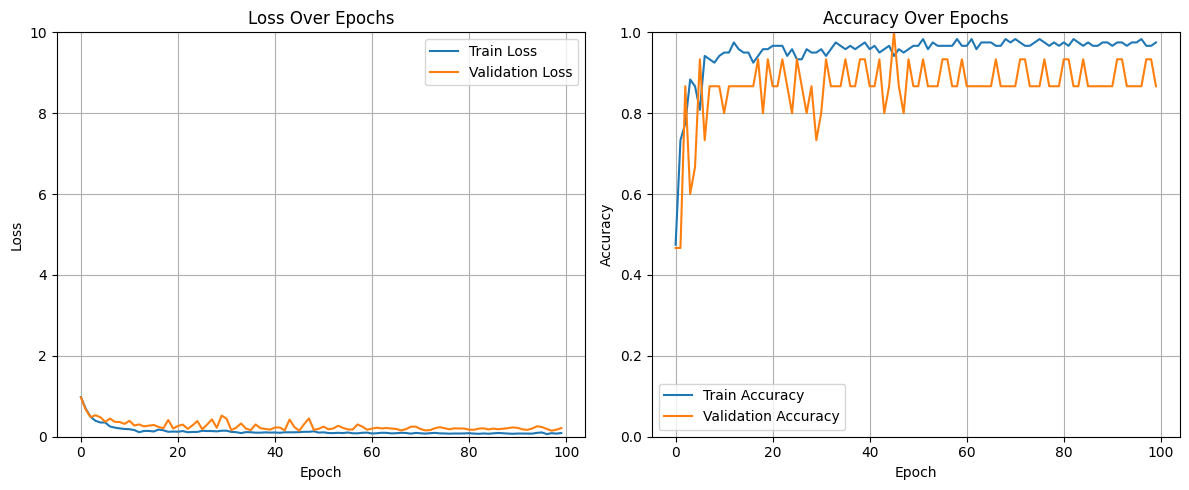

In [22]:
plot_loss_and_accuracy(history)

### Model Testing
After training our model, it's crucial to test its performance on unseen data to ensure it generalizes well. This process involves making predictions on the test dataset and evaluating the results.

**Making Predictions:**

We use the trained model to predict the outcomes for the test dataset (X_test). The predictions are stored in the variable yhat.

In [23]:
yhat = model.predict(X_test)
yhat.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


(15, 3)

**Explanation:**

**Model Predictions:**

We use the **model.predict()** function to generate predictions (yhat) for the test dataset (X_test). This function applies the trained model to the test data and outputs the predicted values.

**Shape Verification:**

By checking the shape of yhat, we confirm that the number of predictions matches the number of samples in X_test. This step ensures consistency and helps verify that our predictions are correctly formatted.

In [24]:
# Convert predicted probabilities to class labels
yhat_labels = np.argmax(yhat, axis=1)

# Convert true one-hot encoded labels to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Display the first few converted labels
print(f"Predicted labels: {yhat_labels[:10]}")
print(f"True labels: {y_test_labels[:10]}")

Predicted labels: [0 1 0 0 1 1 0 0 2 1]
True labels: [0 1 0 0 1 1 0 0 2 1]


#### Evaluation Metrics

This code uses various evaluation metrics from the sklearn.metrics library to measure the accuracy of your model's predictions.

1. **Recall**:

* Definition: Recall (or Sensitivity) measures the proportion of actual positive cases that were correctly identified by the model.

* Calculation: It is calculated for multi-class classification with average='weighted', giving weight to each class based on its frequency.

2. **F1 Score**:

* Definition: The F1 Score is the harmonic mean of Precision and Recall, providing a balance between the two.

* Calculation: It is calculated for multi-class classification with average='weighted', giving weight to each class based on its frequency.

3. **Confussion Matrix**:

* Definition: A confusion matrix is a table used to describe the performance of a classification model by comparing the actual target values with those predicted by the model.

* Components:

    * True Positives (TP): Correctly predicted positive cases.

    * True Negatives (TN): Correctly predicted negative cases.

    * False Positives (FP): Incorrectly predicted positive cases.

    * False Negatives (FN): Incorrectly predicted negative cases.

    * Purpose: The confusion matrix provides a detailed breakdown of the model’s performance, allowing for a better understanding of where the model is making errors.

In [25]:
# Calculate Recall
recall = recall_score(y_test_labels, yhat_labels, average='weighted')
print(f"Recall: {recall}")

# Calculate F1 Score
f1 = f1_score(y_test_labels, yhat_labels, average='weighted')
print(f"F1 Score: {f1}")

Recall: 1.0
F1 Score: 1.0


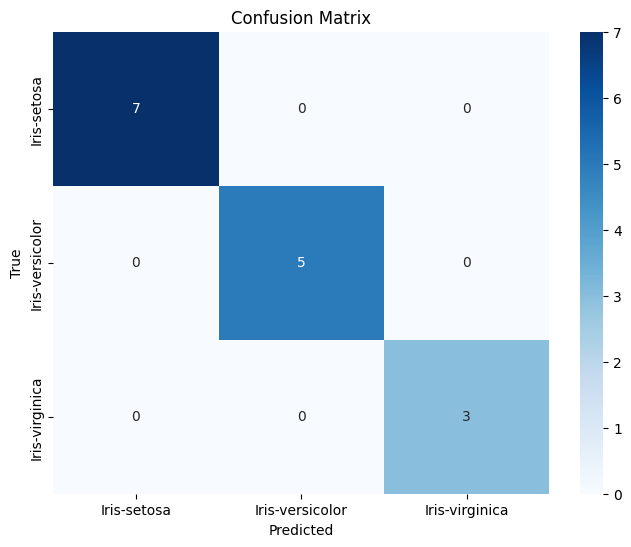

In [26]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_labels, yhat_labels)

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


**Confusion Matrix Analysis**

The confusion matrix for the classification model applied to the Iris dataset is a 3x3 grid with the true labels on the y-axis and the predicted labels on the x-axis. The labels are "Iris-setosa," "Iris-versicolor," and "Iris-virginica." The matrix indicates the following:

* **Iris-setosa**:

    * True Positives (TP): 7 instances of Iris-setosa were correctly classified as Iris-setosa.

    * False Positives (FP): 0

    * False Negatives (FN): 0

* **Iris-versicolor**:

    * True Positives (TP): 5 instances of Iris-versicolor were correctly classified as Iris-versicolor.

    * False Positives (FP): 0

    * False Negatives (FN): 0

* **Iris-virginica**:

    * True Positives (TP): 3 instances of Iris-virginica were correctly classified as Iris-virginica.

    * False Positives (FP): 0

    * False Negatives (FN): 0

**Interpretation**:

Perfect Classification: The model has perfectly classified all instances in this case, with no misclassifications observed. Each class has a 100% accuracy rate for the respective instances.

Color Intensity: The color intensity in each cell represents the number of instances, with darker colors indicating higher counts.

## Results and Interpretation
The model's evaluation metrics indicate outstanding performance, with both Recall and F1 Score achieving a perfect score of 1.0. This suggests that the model has accurately classified all instances in the test set, without any false positives or false negatives. Such performance is rare and demonstrates the model's robustness and precision in distinguishing between different Iris species based on sepal and petal dimensions. Additionally, the confusion matrix results further validate the model’s exceptional performance

### Implications
These results indicate that the model is highly accurate and reliable in classifying Iris flowers. The perfect scores and confusion matrix with no false positives or false negatives highlight the model's effectiveness in identifying the correct class for each instance. This level of accuracy is crucial for applications where precise classification is necessary, such as botanical research and automated plant identification systems.